In [1]:
import os
import numpy as np
from matplotlib.pyplot import imread

In [2]:
path = 'Images/'
files = [os.path.join(path, file) for file in os.listdir(path)][:1000]
np.random.shuffle(files)

In [3]:
food = {food:i for i, food in enumerate(set([file.rsplit('_', 1)[0].rsplit('/', 1)[-1] for file in files]))}
food

{'apple': 14,
 'aubergine': 5,
 'avocado': 8,
 'banana': 23,
 'broccoli': 3,
 'butter': 24,
 'carrot': 6,
 'cherry': 7,
 'cucumber': 21,
 'durian': 10,
 'egg': 2,
 'fennel': 17,
 'fig': 0,
 'grape': 18,
 'kiwi': 9,
 'leek': 12,
 'lemon': 4,
 'mango': 27,
 'meat': 1,
 'melon': 16,
 'noodles': 26,
 'olive': 13,
 'pea': 25,
 'potato': 19,
 'raspberry': 11,
 'rice': 22,
 'strawberry': 20,
 'zucchini': 15}

In [4]:
label = np.eye(len(food))

In [5]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions

Using TensorFlow backend.


In [6]:
images = np.array([image.img_to_array(image.load_img(file, target_size=(299, 299))) for file in files])
n_label = np.array([label[food[file.rsplit('_', 1)[0].rsplit('/', 1)[-1]]] for file in files])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, n_label, test_size=0.2)

del n_label, images

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from keras.optimizers import Adadelta
from keras.losses import categorical_crossentropy

In [8]:
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3(weights='imagenet')

In [9]:
from keras.models import Model

# The model which outputs intermediate layer features
intermediate_layer_model = Model(inputs=model.input, 
                                 outputs=model.layers[311].output)

In [10]:
from keras.layers import Dense

# Connect Dense layers at the end
x = intermediate_layer_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(food), activation='softmax')(x)

# Transfer Learning model
transfer_model = Model(inputs=intermediate_layer_model.input, outputs=predictions)

In [11]:
# Freeze all layers
for layer in transfer_model.layers:
    layer.trainable = False

# Unfreeze last dense layers
transfer_model.layers[312].trainable = True
transfer_model.layers[313].trainable = True

transfer_model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

In [12]:
transfer_model.output_shape
transfer_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________

mixed1 (Concatenate)             (None, 35, 35, 288)   0                                            
____________________________________________________________________________________________________
conv2d_23 (Conv2D)               (None, 35, 35, 64)    18432                                        
____________________________________________________________________________________________________
batch_normalization_23 (BatchNor (None, 35, 35, 64)    192                                          
____________________________________________________________________________________________________
activation_23 (Activation)       (None, 35, 35, 64)    0                                            
____________________________________________________________________________________________________
conv2d_21 (Conv2D)               (None, 35, 35, 48)    13824                                        
___________________________________________________________________________________________

In [13]:
transfer_model.fit(X_train, y_train,
          batch_size=5,
          epochs=1,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 2152s - loss: 3.4895 - acc: 0.0625 - val_loss: 3.1402 - val_acc: 0.0650


In [14]:
score = transfer_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

transfer_model.save_weights('Keras_Food_Model_2.h5')

Test loss: 3.1401527977
Test accuracy: 0.065


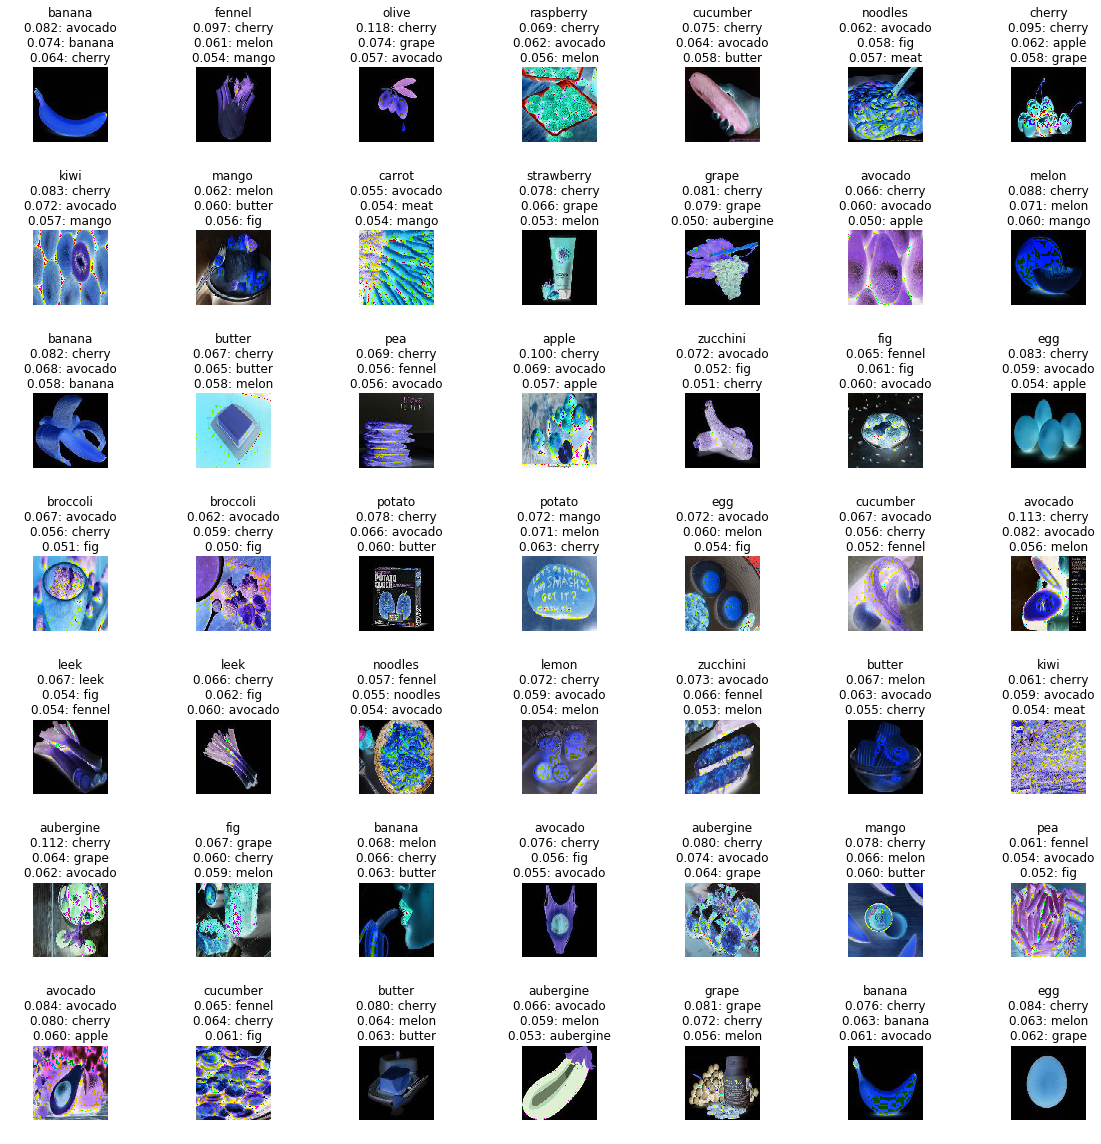

In [15]:
import matplotlib.pyplot as plt

n = 7

food_inv = {j:k for k, j in food.items()}
idx = np.random.choice(np.arange(len(X_test)), n**2, replace=False)
predictions = transfer_model.predict(X_test[idx])

k = 0
f, axarr = plt.subplots(n, n, figsize=(16,16))
for i in range(0,n):
    for j in range(0,n):
        pred_classes = np.flip(predictions[k].argsort(), axis=0)[:3]
        pred_prob = predictions[k][pred_classes]
        pred_label = [food_inv[clas] for clas in pred_classes]
        title = '{}\n{:.3f}: {}\n{:.3f}: {}\n{:.3f}: {}'.format(food_inv[np.argmax(y_test[idx[k]])], pred_prob[0], pred_label[0], pred_prob[1], pred_label[1], pred_prob[2], pred_label[2])
        
        axarr[i,j].imshow(X_test[idx[k]])
        axarr[i,j].set_title(title)
        axarr[i,j].axis('off')
        k += 1
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
predictions = transfer_model.predict(X_test).argmax(axis=1)

df = pd.DataFrame([y_test.argmax(axis=1), predictions]).T
df.columns = ['Label', 'Prediction']
for col in ['Label', 'Prediction']:
    df[col] = df[col].apply(lambda x: food_inv[x])
df['Correct'] = df['Prediction']==df['Label']

df_group = df.groupby('Label').agg({'Prediction':'count', 'Correct':'sum'})
df_group['Ratio'] = df_group['Correct'] / df_group['Prediction']
df_group.sort_values('Ratio', ascending=False).head()

,Prediction,Correct,Ratio
Label,,,
cherry,7,6.0,0.857143
grape,7,2.0,0.285714
avocado,4,1.0,0.250000
leek,9,2.0,0.222222
fennel,5,1.0,0.200000
